In [33]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [34]:
# 시각화 함수

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [35]:
data_path = 'C:/nlp/tensorflow-ml-nlp-tf2/6.CHATBOT/data_in/'
op = 'C:/nlp/tensorflow-ml-nlp-tf2/6.CHATBOT/data_out/'

TRAIN_INPUTS = 'train_inputs_trans.npy'
TRAIN_OUTPUTS = 'train_outputs_trans.npy'
TRAIN_TARGETS = 'train_targets_trans.npy'
DATA_CONFIGS = 'data_configs_trans.json'

In [36]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [37]:
index_inputs = np.load(open(data_path + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(data_path + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(data_path + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(data_path + DATA_CONFIGS, 'r'))

In [38]:
print(prepro_configs['word2idx'])

{'<PAD>': 0, '<SOS>': 1, '<END>': 2, '<UNK>': 3, '우선순위면': 4, '뜻하던': 5, '사겼는데도': 6, '갠톡하면': 7, '생겼네ㅎㅎ': 8, '연기처럼': 9, '그지임': 10, '뛰어야': 11, '만하죠.': 12, '안햇다': 13, '질거': 14, '짝사랑하기도': 15, '발전시켜보세요.': 16, '남았어도': 17, '잊고싶어도': 18, '지워버리자': 19, '옮기세요.': 20, '믿는데': 21, '혼날텐데': 22, '사줘요.': 23, '안들어간다고': 24, '상황에서': 25, '썸녀': 26, '지나서': 27, '필요없는': 28, '전인데': 29, '영원했으면': 30, '반.': 31, '있어': 32, '학교갈': 33, '설레면': 34, '맘도': 35, '전에는': 36, '잘못한게': 37, '읽씹해서': 38, '대리가': 39, '벌려요.': 40, '거절의': 41, '아예': 42, '헤어지면': 43, '행복이었는데': 44, '밥을': 45, '가슴이': 46, '태어났을까': 47, '자자고': 48, '15일이나': 49, '눕지': 50, '누구야?': 51, '수영장': 52, '좋겠어요!': 53, '잠수타는': 54, '끝났네': 55, '다퉜어': 56, '사랑없이': 57, '만났는데도': 58, '모음': 59, '잊질못하네': 60, '모발이': 61, '보았네': 62, '잠에서': 63, '계탔어!': 64, '끝이네': 65, '한답니다.': 66, 'gogo.': 67, '풀어주는': 68, '보름달': 69, '된다': 70, '치우면': 71, '좋아해주세요.': 72, '다행이네요.': 73, '아픔.': 74, '나가세요.': 75, '사야겠지': 76, '썸타는거': 77, '좋지만': 78, '앉는': 79, '첫여친이라': 80, '주는데': 81, '놓치고': 82, '옴?': 83, '뜸해.': 84, '범죄에요.

In [39]:
word2idx = prepro_configs['word2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 64
MAX_SEQUENCE = 25
EPOCHS = 20
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': word2idx[end_index],
         'rate': 0.1
        }

### 순방향 마스크 어텐션(subsequent masked attention)

순환 신경망의 경우 스텝이 존재해 각 스텝마다 단어가 입력으로 들어가는 형태.
트랜스포머 모델의 경우 전제 문장이 한번에 행렬 형태로 입력되는 구조.
이러한 차이점 때문에 문제점이 생김.

예를 들어, 순환 신경망은 문장을 예측하는 과정에서 자신보다 앞에 있는 단어만 참고해서 단어를 예측한다.
하지만 트랜스포머의 경우 전체 문장이 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 예측이 가능하다.

근데 자기 자신도 아직 예측을 하지 않았는데 뒤에 있는 단어를 예측한다는 것은 말이 안되는 상황.
이 문제를 해결하기 위해 자신보다 뒤에 있는 단어를 참고하지 않게하는 기법이 바로 마스크 기법.



In [40]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size. 1 . 1. seq_len)

In [41]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [42]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    
    dec_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask


In [43]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

### 멀티헤드 어텐션

셀프 어텐션에 대한 정보를 하나만 생성해서 모델에서 추론할 수도 있다.
멀티 해드 어텐션은 어텐션 맵을 여럿 만들어 다양한 특징에 대한 어텐션을 볼 수 있게 한 방법이다.

내적 셀프 어텐션에서본 quert, key, value에 대한 특징값을 헤드 수만큼 나눠 리니어 레이어를 거쳐 내적 어텐션을 구해서 다시 합치는 과정을 거친다. 이 과정을 거치고 최종적으로 리니어 레이어를 거쳐 나오면 멀티 헤드 어텐션에 대한 과정을 마친다.

In [44]:
kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': word2idx[end_index],
         'rate': 0.1
        }

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

### 포지션 와이즈 피트포워드 네트워크(position-wise feedforward network)

이 네트워크에서는 셀프 어텐션 레이어를 거친 다음 피드 포워드 네트워크를 거치게 된다.
이 네트워크는 한 문장에 있는 단어 토큰 벡터 각각에 대해 연산하는 네트워크이다.

In [45]:
def position_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(kargs['dff'], activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(kargs['d_model'])  # (batch_size, seq_len, d_model)
    ])


In [46]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angle_rates

In [47]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


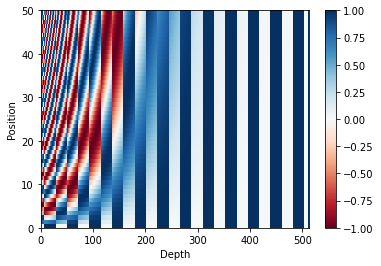

In [48]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 어텐션

In [49]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

### 인코더 레이어

In [50]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = position_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

### 디코더 레이어

In [51]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = position_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
    
    
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### 인코더

In [52]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(**kargs) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

### 디코더

In [53]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

### 트랜스포머

In [54]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, _ = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output
    
    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)        
        enc_output = self.encoder(inp, enc_padding_mask)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
            
        return predict_tokens

### 모델로스

In [55]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [56]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss,
              metrics=[accuracy])

In [57]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = op + model_name + '/weights_transformer.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

C:/nlp/tensorflow-ml-nlp-tf2/6.CHATBOT/data_out/transformer -- Folder create complete 



In [ ]:
history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/20
 52/167 [========>.....................] - ETA: 4:39 - loss: 1.8955 - accuracy: 0.7996

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

In [ ]:

SAVE_FILE_NM = 'weights_transformer.h5'

model.load_weights(os.path.join(op, model_name, SAVE_FILE_NM))

### 결과

In [ ]:
word2idx = prepro_configs['word2idx']
idx2word = prepro_configs['idx2word']

In [ ]:
text = "남자친구 승진 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], word2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2word[str(o)] for o in outputs]))